### Pruebas subplots_gridspec

### 1.- Importación bibliotecas

In [1]:
from pathlib import Path
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle

project_root = Path.cwd().parent  # estando en notebooks/
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

import utils.visualizaciones as vis

# Recarga por si has tocado utils/visualizaciones.py
reload(vis)

<module 'utils.visualizaciones' from 'c:\\Users\\Ramón\\Desktop\\proyecto_comparativa_25_26\\utils\\visualizaciones.py'>

### 2.- Paleta de colores

In [2]:
# --------- PALETA "Dark Cyan" (simplificada) ----------
BG_MAIN       = "#0F1420"   # Fondo principal (casi negro azulado)
BG_SECONDARY  = "#1A2233"   # Fondo secundario (cards / paneles)
TEXT_MAIN     = "#E6EDF3"   # Texto principal
TEXT_SECOND   = "#9DA7B3"   # Texto secundario
TITLE_COLOR   = "#F7FAFC"   # Título (más claro para contraste)
ACCENT_CYAN   = "#00E5FF"   # Acento principal (highlights)
ACCENT_WARN   = "#FFD166"   # Acento secundario (avisos/alertas puntuales)
GRID_COLOR    = "#2B3240"   # Bordes / divisores suaves

# Campo (oscuro, no verde)
PITCH_BG      = "#1A1730"   # Fondo del campo (indigo/morado oscuro)
PITCH_LINES   = "#7CC7E8"   # Líneas del campo (cian suave)

# --------- Estilo base ----------
plt.rcParams.update({
    "figure.facecolor": BG_MAIN,
    "axes.facecolor": BG_MAIN,
    "savefig.facecolor": BG_MAIN,
    "text.color": TEXT_MAIN,
    "axes.labelcolor": TEXT_MAIN,
    "xtick.color": TEXT_SECOND,
    "ytick.color": TEXT_SECOND,
    "axes.edgecolor": GRID_COLOR,
})

### 3.- Funciones complementarias

In [3]:
def tidy_axes(ax, with_frame=True):
    ax.set_xticks([]); ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(with_frame)
        spine.set_color(GRID_COLOR)
        spine.set_linewidth(1)

def place_image(ax, path):
    try:
        if not path or not isinstance(path, str):
            raise FileNotFoundError
        img = mpimg.imread(path)
        ax.imshow(img, interpolation="bilinear")
        ax.set_aspect("equal")
        ax.set_xlim(0, img.shape[1]); ax.set_ylim(img.shape[0], 0)
        ax.margins(x=0, y=0)
        ax.set_anchor('C')
    except FileNotFoundError:
        pass  # no ensuciamos el panel si falta
    tidy_axes(ax, with_frame=False)

def draw_green_pitch(ax, title=None):
    vis.draw_opta_pitch(ax, pitch_color=PITCH_BG, line_color=PITCH_LINES, linewidth=0.9)
    if title:
        ax.set_title(title, fontsize=12, fontweight="bold", color=TITLE_COLOR, pad=6)
    tidy_axes(ax, with_frame=False)

# -------- Título de tarjeta (2 líneas, bien alineado) --------
def paint_title(ax, text, club=None, pos=None, edad=None):
    nombre = text or "Jugador/a"
    linea2 = " · ".join([x for x in [club, pos, (str(edad) if edad is not None else None)] if x])

    # Más aire: L1 (nombre) y L2 bien separadas y pegadas a la izquierda
    ax.text(0.02, 0.90, nombre, va="top", ha="left",
            fontsize=12, fontweight="bold", color=TITLE_COLOR)
    if linea2:
        ax.text(0.02, 0.58, linea2, va="top", ha="left",
                fontsize=10, fontweight="semibold", color=TEXT_SECOND)
    tidy_axes(ax, with_frame=False)

# -------- Barras en stats (dos columnas con aire) --------

def _fmt_int(v): 
    return "—" if pd.isna(v) else f"{int(round(float(v)))}"
def _fmt_pct(v):
    return "—" if pd.isna(v) else f"{float(v):.0f}%"

def _bar(ax, x, y, w, W=0.40, h=0.055, color=ACCENT_CYAN, bg=GRID_COLOR):
    ax.add_patch(Rectangle((x, y), W, h, lw=0, facecolor=bg, alpha=0.35))
    if w is not None:
        ax.add_patch(Rectangle((x, y), max(0, min(1, w))*W, h, lw=0, facecolor=color, alpha=0.9))

def paint_basic_stats(ax, p):
    ax.set_xlim(0, 1); ax.set_ylim(0, 1)
    tidy_axes(ax, with_frame=False)

    TX = 0.01   # columna de texto (más hacia dentro)
    BX = 0.70   # columna de barras (más centrada, no pegada al borde)
    y  = 0.90   # arrancamos un poco más abajo para no comernos el borde
    dy = 0.132

    c = p.get("accent", ACCENT_CYAN)

    ax.text(TX, y, f"Minutos: {_fmt_int(p.get('minutos'))}", ha="left", va="center", fontsize=10); y -= dy

    touches = p.get("toques"); w_touches = None if pd.isna(touches) else min(1, float(touches)/100.0)
    ax.text(TX, y, f"Toques: {_fmt_int(touches)}", ha="left", va="center", fontsize=10)
    _bar(ax, BX, y-0.03, w_touches, color=c); y -= dy

    total = p.get("pases_total"); ok = p.get("pases_ok"); pct = p.get("pases_pct")
    if pd.isna(pct) and not pd.isna(total) and not pd.isna(ok) and float(total)!=0:
        pct = 100*float(ok)/float(total)
    w_pass = None if pd.isna(pct) else float(pct)/100.0
    ax.text(TX, y, f"Pases: {_fmt_int(total)}  (Comp {_fmt_pct(pct)})", ha="left", va="center", fontsize=10)
    _bar(ax, BX, y-0.03, w_pass, color=c); y -= dy

    kp = p.get("pases_clave"); w_kp = None if pd.isna(kp) else min(1, float(kp)/5.0)
    ax.text(TX, y, f"Pases clave: {_fmt_int(kp)}", ha="left", va="center", fontsize=10)
    _bar(ax, BX, y-0.03, w_kp, color=c); y -= dy

    ratt = p.get("reg_int"); rw = p.get("reg_ok"); rpct = p.get("reg_pct")
    if pd.isna(rpct) and not pd.isna(ratt) and not pd.isna(rw) and float(ratt)!=0:
        rpct = 100*float(rw)/float(ratt)
    w_reg = None if pd.isna(rpct) else float(rpct)/100.0
    ax.text(TX, y, f"Regates: {_fmt_int(ratt)}  (Éxito {_fmt_pct(rpct)})", ha="left", va="center", fontsize=10)
    _bar(ax, BX, y-0.03, w_reg, color=c); y -= dy

    tatt = p.get("ent_total"); tsucc = p.get("ent_ok"); tpct = p.get("ent_pct")
    if pd.isna(tpct) and not pd.isna(tatt) and not pd.isna(tsucc) and float(tatt)!=0:
        tpct = 100*float(tsucc)/float(tatt)
    w_tack = None if pd.isna(tpct) else float(tpct)/100.0
    ax.text(TX, y, f"Entradas: {_fmt_int(tatt)}  (Éxito {_fmt_pct(tpct)})", ha="left", va="center", fontsize=10)
    _bar(ax, BX, y-0.03, w_tack, color=c); y -= dy

    tiros = p.get("tiros"); ot = p.get("tiros_OT")
    w_sh = None if pd.isna(tiros) else min(1, float(tiros)/6.0)
    ax.text(TX, y, f"Tiros: {_fmt_int(tiros)}  (a puerta {_fmt_int(ot)})", ha="left", va="center", fontsize=10)
    _bar(ax, BX, y-0.03, w_sh, color=c)

# -------- Imagen con tamaño físico fijo (foto pequeña, escudo/bandera iguales) --------
def place_fixed_image(ax_host, path, size_in=1.50):
    try:
        if not path or not isinstance(path, str):
            raise FileNotFoundError
        ax_img = inset_axes(ax_host, width=size_in, height=size_in, loc=10, borderpad=0)
        img = mpimg.imread(path)
        ax_img.imshow(img, interpolation="bilinear")
        ax_img.axis("off")
    except FileNotFoundError:
        pass
    tidy_axes(ax_host, with_frame=False)

### 4.- Selección métricas

In [4]:
# --- Parámetros y helpers (NO dibuja nada) ---

SELECTED_POSITION = "mc"  # ej.: "centrales","laterales","mc","extremos","delanteros","porteros"

# Usa tus IDs WhoScored del master que pasaste
PLAYER_IDS = [484451, 484453, 560214]  # Aitana, Alexia, Patri (ajusta el orden si quieres)

# Rutas (ajústalas a tu estructura)
PATH_MASTER_PLAYERS = "../data/masters/master_jugadores.csv"   # con playerID, name, team, etc.
# (Si de momento solo quieres tirar de master, no necesitas cargar WhoScored/FBref aquí)

# --- Datos del partido (WhoScored) ---
PATH_FEATURES_MATCH = "../data/matches/Final_EuroWJ_ING_ESP_features_jugadores.csv"  # cámbialo por la jornada
MIN_MINUTES = 0

METRICS_BY_POSITION = {
    "mc": [
        ("Pases clave",        ["KeyPasses","Pases_clave","passing_KP"]),
        ("Pases prog/90",      ["ProgPassesPer90","Pases_Progresivos","stats_PrgP"]),
        ("xA",                 ["xA","passing_xA"])
    ],
    # añade el resto si quieres…
}

def load_master(path):
    # Detecta separador de forma simple y lee el CSV
    import io
    with open(path, "r", encoding="utf-8") as f:
        first = f.readline()
    sep = ";" if (";" in first and "," not in first) else ","
    m = pd.read_csv(path, sep=sep, encoding="utf-8")
    m.columns = [c.strip() for c in m.columns]
    return m

def load_features(path):
    f = pd.read_csv(path, encoding="utf-8")
    f.columns = [c.strip() for c in f.columns]
    return f

def pick_metric(row, candidates, default=np.nan):
    for c in candidates:
        if c in row.index and pd.notna(row[c]):
            return row[c]
    return default

def _col(df, options):
    """Devuelve el primer nombre de columna que exista en df."""
    for c in options:
        if c in df.columns:
            return c
    return None

def build_profiles(player_ids, selected_position):
    m = load_master(PATH_MASTER_PLAYERS)
    f = load_features(PATH_FEATURES_MATCH)

    # Columnas master (flexibles como ya hacías)
    col_id   = _col(m, ["playerID","playerId","player_id","id"])
    col_name = _col(m, ["nick_name","name","name_ws","nameWS"])   # prioriza nick
    col_team = _col(m, ["nick_team","team","teamName","Squad","Equipo"])
    col_pos  = _col(m, ["nick_position","position","pos","Pos"])
    col_nat  = _col(m, ["nacionalidad","Nation","Nacionalidad"])
    col_foto = _col(m, ["foto_local","foto_path","foto","image_path"])
    col_logo = _col(m, ["logo_local","logo_path"])
    col_flag = _col(m, ["flag_local","flag_path"])

    if col_id is None:
        raise ValueError(f"No encuentro columna de ID en master. Tengo: {list(m.columns)}")

    # Filtrado por IDs y orden original
    ids_series = m[col_id].astype(str)
    wanted     = list(map(str, player_ids))
    sel = m[ids_series.isin(wanted)].copy()
    sel["__order"] = pd.Categorical(ids_series[sel.index], categories=wanted, ordered=True)
    sel = sel.sort_values("__order").drop(columns="__order")

    # Features del PARTIDO (brutas) filtradas por minutos
    f["playerId"] = f["playerId"].astype(str)
    f_ok = f[f.get("minutes", 0) >= MIN_MINUTES].copy()
    cols_feat = [
        "playerId","age","minutes","s_touches","s_passesTotal","s_passesAccurate","s_passSuccess",
        "s_passesKey","s_dribblesAttempted","s_dribblesWon","s_dribbleSuccess",
        "s_tacklesTotal","s_tackleSuccessful","s_tackleSuccess","s_interceptions",
        "s_shotsTotal","s_shotsOnTarget"  # por si quieres “Tiros” más adelante
    ]
    for c in cols_feat:
        if c not in f_ok.columns: f_ok[c] = np.nan

    # Merge master + features
    mm = sel.rename(columns={col_id: "playerId"})
    mm["playerId"] = mm["playerId"].astype(str)
    merged = mm.merge(f_ok[cols_feat], on="playerId", how="left")

    profiles = []
    for _, r in merged.iterrows():
        p = {
            "playerId": r["playerId"],
            "nombre":   r.get(col_name),
            "club":     r.get(col_team),
            "pos":      r.get(col_pos),
            "nac":      r.get(col_nat),
            "foto":     f"../{r.get(col_foto)}" if (col_foto and isinstance(r.get(col_foto), str)) else None,
            "logo":     f"../{r.get(col_logo)}" if (col_logo and isinstance(r.get(col_logo), str)) else None,
            "flag":     f"../{r.get(col_flag)}" if (col_flag and isinstance(r.get(col_flag), str)) else None,
            "edad":     (None if pd.isna(r.get("age")) else int(r.get("age"))),

            # partido (bruto)
            "minutos":  r.get("minutes"),
            "toques":   r.get("s_touches"),
            "pases_total": r.get("s_passesTotal"),
            "pases_ok":    r.get("s_passesAccurate"),
            "pases_pct":   r.get("s_passSuccess"),
            "pases_clave": r.get("s_passesKey"),
            "reg_int":     r.get("s_dribblesAttempted"),
            "reg_ok":      r.get("s_dribblesWon"),
            "reg_pct":     r.get("s_dribbleSuccess"),
            "ent_total":   r.get("s_tacklesTotal"),
            "ent_ok":      r.get("s_tackleSuccessful"),
            "ent_pct":     r.get("s_tackleSuccess"),
            "inter":       r.get("s_interceptions"),
            "tiros":       r.get("s_shotsTotal"),
            "tiros_OT":    r.get("s_shotsOnTarget"),
        }
        profiles.append(p)

    # Aviso si alguien quedó fuera por minutos
    got = set(merged["playerId"].astype(str))
    missing = [pid for pid in wanted if pid not in got]
    if missing:
        print(f"⚠️ Fuera por minutos (<{MIN_MINUTES}): {missing}")

    return profiles

# Ejecuta y deja ‘profiles’ listo para usar en la Celda 5
profiles = build_profiles(PLAYER_IDS, SELECTED_POSITION)


### 5.- Función de despliegue

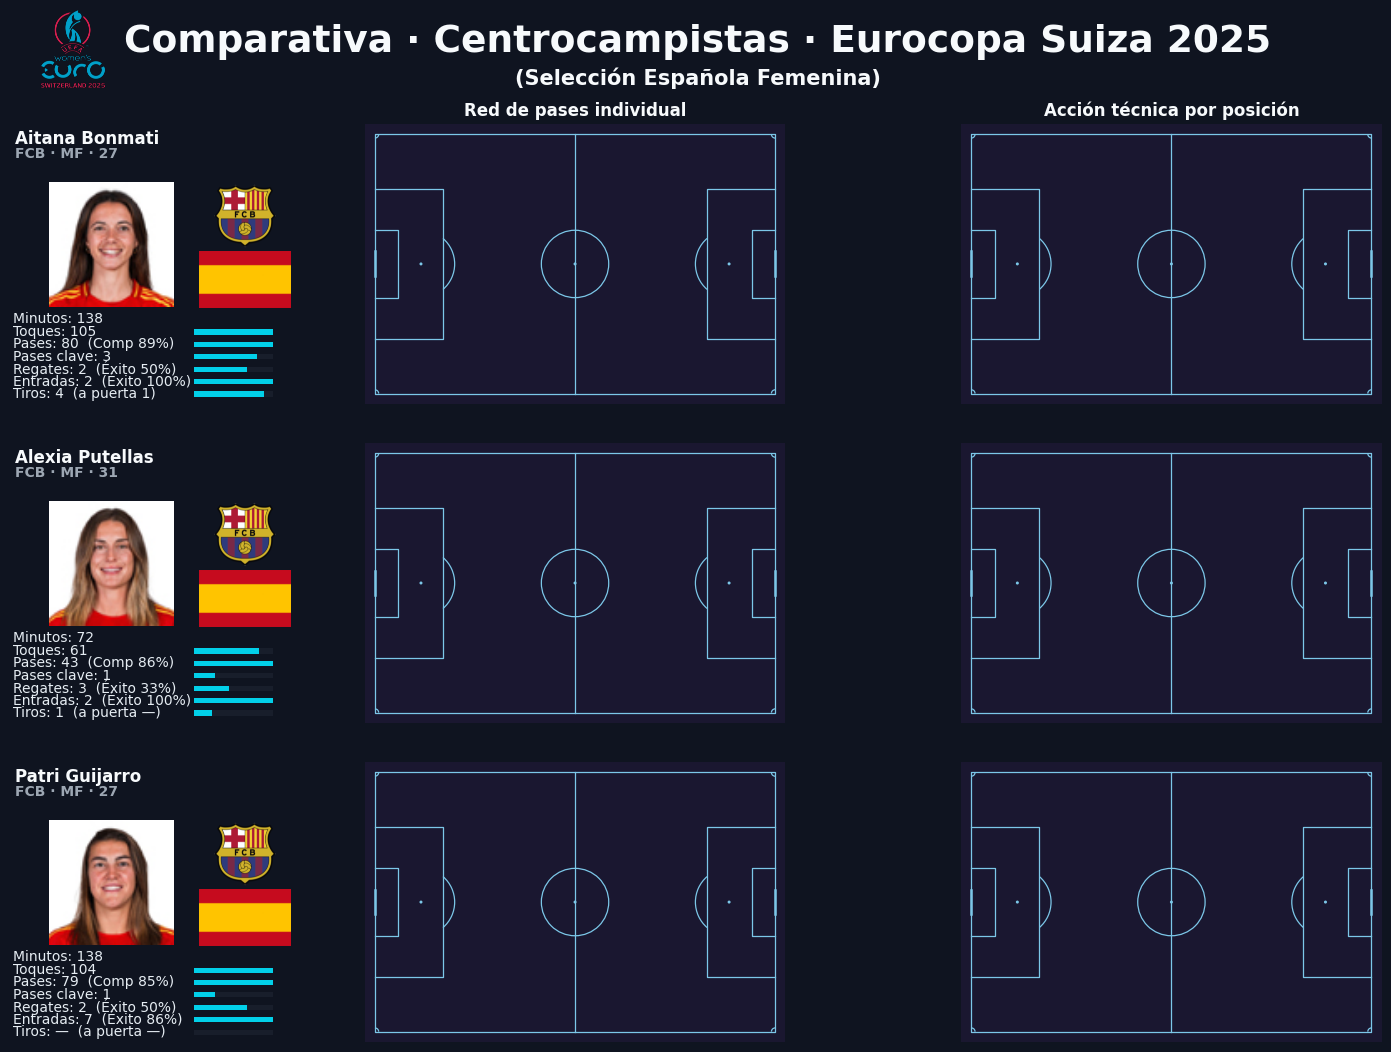

In [5]:
# --------- FIGURA & GRID ---------
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(
    3, 3,
    width_ratios=[1.05, 2.35, 2.35],   # un pelín más para la col 0
    wspace=0.015,                      # antes 0.009 ya era muy bajo; 0.015 evita solapes
    hspace=0.14
)

# Col 0: (título) + (foto | [escudo/flag]) + (stats)
ax_name, ax_photo, ax_logo, ax_flag, ax_stats = [], [], [], [], []
for r in range(3):
    
    gcol0 = gs[r, 0].subgridspec(3, 1, height_ratios=[0.20, 0.46, 0.34], hspace=0.02)

    # 0a) título (sólo texto)
    ax_name.append(fig.add_subplot(gcol0[0, 0]))
    tidy_axes(ax_name[-1], with_frame=False)

    # 0b) fila de imágenes: [foto | (escudo/flag apilados)]
    gimgs   = gcol0[1, 0].subgridspec(1, 2, width_ratios=[0.78, 0.22], wspace=0.015)
    ax_photo.append(fig.add_subplot(gimgs[0, 0]))
    gbadges = gimgs[0, 1].subgridspec(2, 1, height_ratios=[0.55, 0.45], hspace=0.015)
    ax_logo.append(fig.add_subplot(gbadges[0, 0]))
    ax_flag.append(fig.add_subplot(gbadges[1, 0]))
    tidy_axes(ax_photo[-1], False); tidy_axes(ax_logo[-1], False); tidy_axes(ax_flag[-1], False)

    # 0c) bloque de stats (texto)
    ax_stats.append(fig.add_subplot(gcol0[2, 0]))
    tidy_axes(ax_stats[-1], with_frame=False)

# Col 1: Redes de pase (3) con campo
ax_red = [fig.add_subplot(gs[r, 1]) for r in range(3)]
for i, ax in enumerate(ax_red):
    draw_green_pitch(ax, title="Red de pases individual" if i == 0 else None)

# Col 2: Acción técnica (3) con campo
ax_accion = [fig.add_subplot(gs[r, 2]) for r in range(3)]
for i, ax in enumerate(ax_accion):
    draw_green_pitch(ax, title="Acción técnica por posición" if i == 0 else None)

# Título global
# --- TÍTULO PRINCIPAL + SUBTÍTULO (tamaños separados) ---
main_title = "Comparativa · Centrocampistas · Eurocopa Suiza 2025"
sub_title  = "(Selección Española Femenina)"

# 1) Sube un poco el margen superior para dejar “cabecera” para logo + dos líneas
plt.subplots_adjust(top=0.875, left=0.07, right=0.98)

# 2) Título principal grande
fig.suptitle(main_title, fontsize=27, fontweight="bold", color=TITLE_COLOR, y=0.958, ha="center")

fig.text(0.5, 0.922, sub_title, ha="center", va="top", fontsize=15, fontweight="semibold", color=TITLE_COLOR)

# 4) Logo del torneo (corrige la RUTA: usa el mismo patrón de '../images/...'):
logo_ax = fig.add_axes([0.082, 0.905, 0.055, 0.065])  # x, y, w, h
place_image(logo_ax, "../images/logos/eurowomen.png")


# --- PINTAR TÍTULO, IMÁGENES Y STATS EN LA COLUMNA 0 ---
for i, p in enumerate(profiles):
    # título en cian (nombre corto si existe)
    nombre = p.get("nombre") or "Jugador/a"
    paint_title(ax_name[i], p.get("nombre"), club=p.get("club"), pos=p.get("pos"), edad=p.get("edad"))

    # imágenes
    place_fixed_image(ax_photo[i], p.get("foto"), size_in=1.25)  # foto más compacta
    place_fixed_image(ax_logo[i],  p.get("logo"), size_in=0.92)
    place_fixed_image(ax_flag[i],  p.get("flag"), size_in=0.92)

    # stats básicas
    paint_basic_stats(ax_stats[i], p)

plt.show()
